# Kaggle

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"iamsdt","key":"0c6c538ce3a4b58c0dc2b3b25167dce1"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!ls

 98% 329M/337M [00:07<00:00, 48.6MB/s]
100% 337M/337M [00:08<00:00, 43.8MB/s]
cell-images-for-detecting-malaria.zip  kaggle.json  sample_data


Extract zip file

In [0]:
#unzip
!unzip cell-images-for-detecting-malaria.zip
print("Done")

# Train Part

## Perepare Data 

In [0]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

data_dir = "cell_images"
classes = ["Parasitized", "Unifected"]

train_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(244),
    transforms.RandomCrop(224),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(244),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(data_dir, transform=train_transforms)
test_data = datasets.ImageFolder(data_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(data_dir, transform=valid_transforms)

print("Train Data Size: ", len(train_data))

batch_size = 650

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Train Data Loader Size: ", len(train_loader))

Train Data Size:  27558
Train Data Loader Size:  37


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


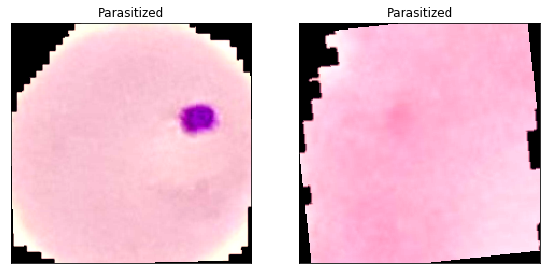

In [0]:
# visualize data
import numpy as np
from matplotlib import pyplot as plt

data_iter = iter(train_loader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25,5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # un normalize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))  # transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])


## Prepare Model

In [0]:
model = models.densenet121(pretrained=True)
model.classifier

Linear(in_features=1024, out_features=1000, bias=True)

Freeze parameters

In [0]:
# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

In [0]:
import torch.nn as nn

classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 100),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(100, 2),
    nn.LogSoftmax(dim=1)
)

model.classifier = classifier
model.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2)
  (3): Linear(in_features=512, out_features=256, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2)
  (6): Linear(in_features=256, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2)
  (9): Linear(in_features=100, out_features=2, bias=True)
  (10): LogSoftmax()
)

In [0]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.03)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

## Train Part

In [71]:
epochs = 1
steps = 0
running_loss = 0
print_every = 2
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs} & Steps {steps} ...  "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(valid_loader):.3f}.. "
                  f"Test accuracy: {(accuracy/len(valid_loader))*100 :.3f}%")
            running_loss = 0
            model.train()

Epoch 1/1 & Steps 2 ...  Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 50.040%
Epoch 1/1 & Steps 4 ...  Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 49.995%
Epoch 1/1 & Steps 6 ...  Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 49.984%
Epoch 1/1 & Steps 8 ...  Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 49.986%
Epoch 1/1 & Steps 10 ...  Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 50.021%
Epoch 1/1 & Steps 12 ...  Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 50.011%
Epoch 1/1 & Steps 14 ...  Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 49.999%
Epoch 1/1 & Steps 16 ...  Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 49.993%
Epoch 1/1 & Steps 18 ...  Train loss: 0.694.. Test loss: 0.693.. Test accuracy: 50.006%
Epoch 1/1 & Steps 20 ...  Train loss: 0.693.. Test loss: 0.693.. Test accuracy: 50.014%


KeyboardInterrupt: ignored

In [0]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

with torch.no_grad():
  model.eval()
  # iterate over test data
  for data, target in test_loader:
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(38):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.693327

Test Accuracy of Parasitized:  0% ( 0/722)
Test Accuracy of Unifected: 100% (684/684)


IndexError: ignored